# EEG Wheelchair Binary Classification ML Model
## Using 1D Convolutional Networks and Recurrent Networks
This is the first experiment with trying to convert 4 channel EEG brain wave data into a binary classification of stop and go for the EEG wheelchair control system.

## Overview
The following notebook will follow these next steps:
1. Data Cleaning
    - Get rid of inconsistent samples or bad samples
2. Data Preprocessing
    - Convert to wavelet transforms and take signal squeezed signals
3. Data Filtering
    - Filter out irrelevant frequencies and disconnections
4. Build Model
    - Form CNN-RNN network for prediction modelling
5. Model Training
    - Train model on training set of EEG Samples
6. Hyperparameter Optimization
    - Optimize model hyperparameters by cross validation 
7. Model Validation
    - Validate model on test set


In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()


In [1]:
# Basic imports
from datetime import datetime
import numpy as np
import glob
import os
import sys
from collections import defaultdict
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

# Data management
import pandas as pd

# Data processing
from ssqueezepy import ssq_cwt

# Model training
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, TimeDistributed, Concatenate, Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, AveragePooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import matplotlib.pyplot as plt

## Experiment Information
Record the experiment information in these fields to be saved with the experiment

In [2]:
trial_num = 3
attempt_num = 9
input_dim = 195
output_dim = 3
attempt_description = \
"""
## 9th attempt - Multi channel Test

### Changes made
- Trying the model with different dataset found online
    - https://www.nature.com/articles/sdata2018211
- Using the LR hand paradigm
- Data inforamtion:
    - Original model, 34 samples per prediction
    - 4 Channels
- Changing the input data shape
    - from (frame, sample, height, channel)
    - to (frame, channel, sample, height)
- Building a new model
    - Seperating model into 4 different channels before running
- Experimenting different CNN architectures to find the optimal
    - Trying to add more layers to the CNN
    - Changing CNN sizing to see effect
    - Changing CNN stride size and kernel size and see effect
- GRU Recurrent network
- learning rate of 0.01

### Expected results
- See if we can get more validation and training data correlation

### Issues noticed
- Looks like training could not pass 50% accuracy
    - likely means that model with multiple channels could not understand the data
- Increasing the sample size seems to improve the accuracy by can't do more than that
 
"""

In [3]:
# Make directories to save data
model_dir = './models/trial%s' % trial_num
results_dir = './results/trial%s/attempt%s' % (trial_num, attempt_num)
interm_dir = './processed_data/trial%s/attempt%s' % (trial_num, attempt_num)

model_file = os.path.join(model_dir, 'attempt%s_%s.h5' % (attempt_num, input_dim))
description_file = os.path.join(results_dir, 'attempt%s_readme.md' % attempt_num)
accuracy_graph = os.path.join(results_dir, 'attempt%s_accuracy.png' % attempt_num)
loss_graph = os.path.join(results_dir, 'attempt%s_loss.png' % attempt_num)
conf_matrix = os.path.join(results_dir, 'attempt%s_confusion.png' % attempt_num)
log_file = os.path.join(results_dir, 'attempt%s.log' % attempt_num)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
if not os.path.exists(interm_dir):
    os.makedirs(interm_dir)
    
# Save description
with open(description_file, 'w') as f:
    f.write(attempt_description)
    f.close()


## Importing Data

In [ ]:
#### FOR RUNNING OPENBCI DATA ####
import scipy.io
mat = scipy.io.loadmat('./datasets/openbci_dataset/CLA-SubjectJ-170508-3St-LRHand-Inter.mat')
mat2 = scipy.io.loadmat('./datasets/openbci_dataset/CLA-SubjectJ-170510-3St-LRHand-Inter.mat')
data = np.concatenate((mat['o']['data'][0][0], mat2['o']['data'][0][0]))
labels = np.concatenate((mat['o']['marker'][0][0].flatten(),mat2['o']['marker'][0][0].flatten()))
print(labels.shape, data.shape)

### Try test file

In [ ]:
# Try test file

# Convert to numpy arrays
tp9, af7, af8, tp10 = data[621892-1000:621892+1000].T[:4]

# Get the frequency of the samples 
Twtp9, Wtp9, *_ = ssq_cwt(tp9, fs=200)

fig = plt.figure(figsize=(20, 20))
fig.add_subplot(4, 1, 1)
plt.plot(data[621892-1000:621892+1000])
fig.add_subplot(4, 1, 3)
plt.imshow(np.abs(Twtp9), aspect='auto', cmap='turbo')
fig.add_subplot(4, 1, 2)
plt.imshow(np.abs(Wtp9), aspect='auto', cmap='turbo')
fig.add_subplot(4, 1, 4)
plt.plot(labels[621892-1000:621892+1000])
plt.show()


In [ ]:
##### For our data
segments = defaultdict(list)

# Number of samples per file
SEGMENT_SIZE = 170

# Number of channels per file
CHANNELS = [1, 2, 17, 18]
# CHANNELS = [i for i in range(1,23)]

# label_map = {1: "LEFT",
#              2: "RIGHT",
#              3: "PASSIVE",
#              0: "REMOVED"}

# Only use the left right passive signals
label_map = {1: "LEFT",
             2: "RIGHT",
             3: "PASSIVE"}

# Compile each 1s session into file
segment = []
for i in range(len(labels)):
    try:
        label = label_map[labels[i]]
    except KeyError:
        continue
    # Append the previous file and open new file
    if i+1 == len(labels) or labels[i] != labels[i+1] or len(segment) == SEGMENT_SIZE:
        # Split any that are large then FILE_SIZE and discard any that is smaller
        if len(segment) == SEGMENT_SIZE:
            segments[label].append(np.array(segment).T)
        segment = []
        
    segment.append(np.take(data[i], [chan - 1 for chan in CHANNELS]))
    
    
print("Total:")
for val in label_map.values():
    print('    There are %d segments with %s label of shape %s' % (len(segments[val]), val, segments[val][0].shape))
    
max_num_segments = min([len(segments[key]) for key in label_map.values()])

train_segments = defaultdict(list)
test_segments = defaultdict(list)
val_segments = defaultdict(list)

#             [train, test, vali]
split_ratio = [0.8, 0.1, 0.1]

# Split the data to training test and val
for key in label_map.values():
    train_segments[key], test_segments[key], val_segments[key] = \
            np.split(shuffle(segments[key])[:max_num_segments], # Shuffle the data
                     [int(sum(split_ratio[:i+1])*max_num_segments) for i in range(len(split_ratio)-1)])

print("Training: ")
for val in label_map.values():
    print('    There are %d segments with %s label of shape %s' % (len(train_segments[val]), val, train_segments[val].shape))
    
print("Testing: ")
for val in label_map.values():
    print('    There are %d segments with %s label of shape %s' % (len(test_segments[val]), val, test_segments[val].shape))
    
print("Validation: ")
for val in label_map.values():
    print('    There are %d segments with %s label of shape %s' % (len(val_segments[val]), val, val_segments[val].shape))
    

## Convert to wavelet transform signal squeezed

In [ ]:
SAMPLE_RATE = 200
def ts_to_ssq(timeseries):
    """
    Converts x channel time series data to ssq wavelet transform
    """
    ssqcwt = []
    for channel in timeseries:
        out, _, *_ = ssq_cwt(channel, fs=SAMPLE_RATE)
        ssqcwt.append(out)
    
    return np.array(ssqcwt)

In [ ]:
original_frame_size = SEGMENT_SIZE
buffer_frame_size = SEGMENT_SIZE # 0.85s
training_frame_size = 34
# training_sample_size = SEGMENT_SIZE

key_dict = {"LEFT":(1.0, 0.0, 0.0),
            "RIGHT":(0.0, 1.0, 0.0),
            "PASSIVE": (0.0, 0.0, 1.0)}


def compile_segments(segments, seg_type):
    X = []
    t = []
    
    num_segments = sum([len(x) for x in segments.values()])
    
    for key, data in segments.items():
        for recording in data:
            # if segment is smaller than sample size
            if len(recording[0]) < original_frame_size:
                continue

            # Split file into buffer size samples
            time_samples = np.split(recording,
                                    int(original_frame_size/buffer_frame_size), axis=1)

            for time_sample in time_samples:
                # Convert to numpy arrays
                ssq_data = ts_to_ssq(time_sample)

                # Take the magnitude of the wavelet transform only
                ssq_data = np.abs(ssq_data)

                # Split sample into many blocks
                wavelet_samples = np.split(ssq_data, int(buffer_frame_size/training_frame_size))

                X.extend(wavelet_samples)
                t.extend([key_dict[key] for i in range(len(wavelet_samples))])
                
            num_segments -= 1
            
            print("%d %s segments left to convert " % (num_segments, seg_type), end="\r")
                
    return np.array(X), np.array(t)

In [ ]:
# Compile all files into train data
X_train, t_train = compile_segments(train_segments, 'train')

X_test, t_test = compile_segments(test_segments, 'test')

X_val, t_val = compile_segments(val_segments, 'val')

In [ ]:
print("Training data")
print(X_train.shape)
print(t_train.shape)
print("Testing data")
print(X_test.shape)
print(t_test.shape)
print("Validation data")
print(X_val.shape)
print(t_val.shape)

In [ ]:
# Save the ssq data
np.save(os.path.join(interm_dir, 'x_train.npy'), X_train)
np.save(os.path.join(interm_dir, 't_train.npy'), t_train)
np.save(os.path.join(interm_dir, 'x_test.npy'), X_test)
np.save(os.path.join(interm_dir, 't_test.npy'), t_test)
np.save(os.path.join(interm_dir, 'x_val.npy'), X_val)
np.save(os.path.join(interm_dir, 't_val.npy'), t_val)


## *Shortcut: Load Preprocessed Saved Data*

In [27]:
# Load ssq data
interm_dir = './processed_data/trial3/attempt1/'
X_train = np.load(os.path.join(interm_dir, 'x_train.npy'))
t_train = np.load(os.path.join(interm_dir, 't_train.npy'))
X_test = np.load(os.path.join(interm_dir, 'x_test.npy'))
t_test = np.load(os.path.join(interm_dir, 't_test.npy'))
X_val = np.load(os.path.join(interm_dir, 'x_val.npy'))
t_val = np.load(os.path.join(interm_dir, 't_val.npy'))

## Shuffle data

In [28]:
# Shuffle the data
X_train, t_train = shuffle(X_train, t_train)
X_test, t_test = shuffle(X_test, t_test)
X_val, t_val = shuffle(X_val, t_val)

In [ ]:
X_train_full = X_train
X_train = X_train[:1000]
t_train_full = t_train
t_train = t_train[:1000]

In [ ]:
X_train = to_categorical(X_train, 3)

In [ ]:
X_train = np.zeros((4, 2718, 195, 85))
t_train = np.zeros((2718, 3))

X_val = np.zeros((4, 2718, 195, 85))
t_val = np.zeros((2718, 3))

In [31]:
# Reshape the data for training
X_train = X_train.transpose(3, 0, 1, 2)

X_test = X_test.transpose(3, 0, 1, 2)

# Reshape the data for training
X_val = X_val.transpose(3, 0, 1, 2)

In [32]:
X_train.shape

(4, 678, 170, 195)

In [30]:
t_train.shape

(678, 3)

In [ ]:
counts = [0, 0, 0]
for data in t_train:
    for i in range(3):
        if data[i] == 1:
            counts[i] += 1
  
print("Balance of categories")
print(counts)

## Train Model

In [50]:
num_frames = len(X_train[0])
num_channels = len(X_train)
frame_size = len(X_train[0][0])
sample_height = len(X_train[0][0][0])

inputs = []
cnn_out = []

print('Training data dimensions = (%s, %s, %s, %s)' % (num_frames, num_channels, frame_size, sample_height))

for channel_num in range(num_channels):
    # Input layer
    input_layer = Input(shape=(frame_size, sample_height, 1))

    # 1st Conv
    conv1d = TimeDistributed(
                Conv1D(filters=256, kernel_size=(5), strides=1, padding='same', activation='relu'))(input_layer)
    conv1d = TimeDistributed(
                Conv1D(filters=256, kernel_size=(5), strides=1, padding='same', activation='relu'))(conv1d)
    
    # Pooling layer
    pool = TimeDistributed(
                MaxPooling1D(pool_size=(2), strides=2))(conv1d)
    
    
    conv1d = TimeDistributed(
                Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', activation='relu'))(pool)
    
        # Pooling layer
    pool = TimeDistributed(
                MaxPooling1D(pool_size=(2), strides=2))(conv1d)
    
    flatten = TimeDistributed(Flatten())(pool)
    
    cnn_out.append(flatten)
    inputs.append(input_layer)
    
# Concatenate all channels
concat = Concatenate()(cnn_out)

# Get recurrent network for time distributed\
lstm = GRU(128, activation='relu', return_sequences=True)(concat)
lstm = GRU(128, activation='relu', return_sequences=False)(lstm)

# FIXME: This part is too big
# Get flattened of time distributed
# time_flat = Flatten()(concat)
# # # Do convolution on time flattened
# reshape = Reshape(time_flat.shape[1:] + (1,))(time_flat)
# time_conv1d = Conv1D(filters=64*num_channels, kernel_size=(5))(reshape)

# concat = Concatenate()([Flatten()(time_conv1d), lstm])

# final interpretation layers
drop = Dropout(0.2)(lstm)
dense = Dense(128, activation='relu', kernel_regularizer='l2', bias_regularizer='l2')(drop)
dense = Dense(64, activation='relu', kernel_regularizer='l2', bias_regularizer='l2')(dense)
drop = Dropout(0.5)(dense)
dense = Dense(48, activation='relu', kernel_regularizer='l2', bias_regularizer='l2')(drop)
drop = Dropout(0.4)(dense)

output = Dense(len(t_train[0]), activation='softmax')(drop)
    
model = Model(inputs=inputs, outputs=output)
    
    

Layer gru will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
Layer gru_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


In [51]:
adam = Adam(learning_rate=0.01, beta_1=0.99, beta_2=0.9999)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2023-02-22 23:06:31.158239: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: Tesla K20Xm computeCapability: 3.5
coreClock: 0.732GHz coreCount: 14 deviceMemorySize: 5.57GiB deviceMemoryBandwidth: 232.46GiB/s
2023-02-22 23:06:31.158404: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-22 23:06:31.158484: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-22 23:06:31.158557: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-22 23:06:31.158639: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-02-22 23:06:31.158735: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10


In [45]:
model.summary()

In [ ]:
model.get_weights()

In [44]:
sys.stdout = stdout
f.close()

In [ ]:
stdout = sys.stdout
f = open(log_file, 'w')
sys.stdout = f
with tf.device('/CPU:0'):
    results = model.fit(list(X_train), t_train, validation_data=(list(X_val), t_val), batch_size=17, epochs=100)
sys.stdout = stdout
f.close()

In [54]:
# To save the model
model.save(model_file)

In [ ]:
model = tf.keras.models.load_model(model_file)

In [55]:
test_results = model.evaluate(list(X_test), t_test, batch_size = 1)

In [56]:
model.predict(list(X_test))

2023-02-24 10:46:25.116749: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-24 10:46:25.116824: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2023-02-24 10:46:35.453181: W tensorflow/core/common_runtime/bfc_allocator.cc:434] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.01GiB (rounded to 1086259200)
Current allocation summary follows.
2023-02-24 10:46:35.453398: I tensorflow/core/common_runtime/bfc_allocator.cc:934] BFCAllocator dump for GPU_0_bfc
2023-02-24 10:46:35.453436: I tensorflow/core/common_runtime/bfc_allocator.cc:941] Bin 

ResourceExhaustedError:  OOM when allocating tensor with shape[5440,256,1,195] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/time_distributed_12/conv1d_6/conv1d (defined at tmp/ipykernel_251755/2155851930.py:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_65980]

Function call stack:
predict_function


In [ ]:
t_test

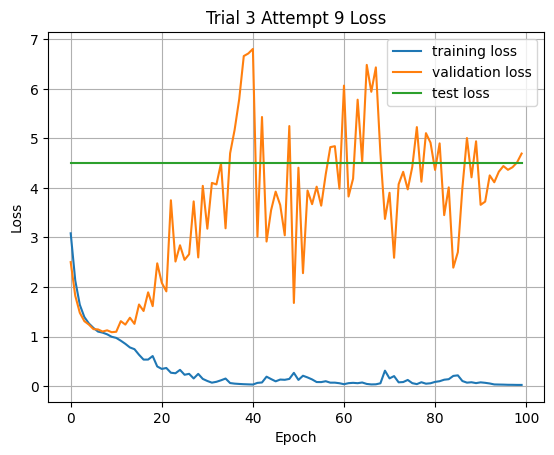

In [57]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.plot([test_results[0] for i in range(len(results.history['loss']))])
plt.legend(('training loss', 'validation loss', 'test loss'))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Trial %s Attempt %s Loss" % (trial_num, attempt_num))
plt.grid()
plt.savefig(loss_graph)

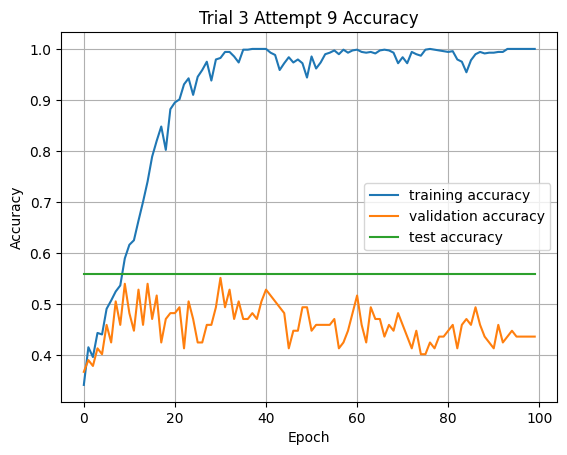

In [58]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.plot([test_results[1] for i in range(len(results.history['accuracy']))])
plt.legend(('training accuracy', 'validation accuracy', 'test accuracy'))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Trial %s Attempt %s Accuracy" % (trial_num, attempt_num))
plt.grid()
plt.savefig(accuracy_graph)

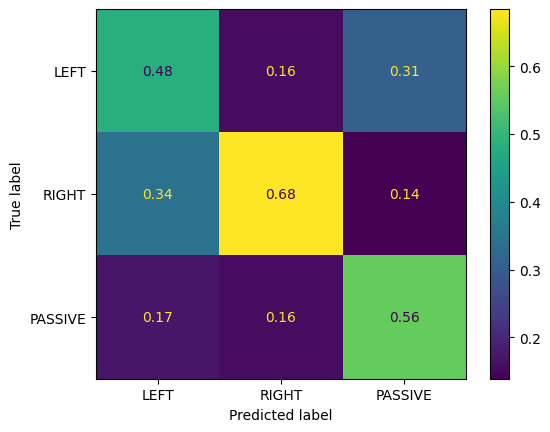

In [61]:
with tf.device('/CPU:0'):
    y_pred = model.predict(list(X_test))
    
key_dict = {"LEFT":(1.0, 0.0, 0.0),
            "RIGHT":(0.0, 1.0, 0.0),
            "PASSIVE": (0.0, 0.0, 1.0)}
    
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(t_test, axis=1)

cm = confusion_matrix(y_test, y_pred, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=key_dict.keys())
plot = disp.plot()
disp.figure_.savefig(conf_matrix)

In [49]:
tf.keras.backend.clear_session()